In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import string
from bs4 import BeautifulSoup
import json
import numpy as np

In [2]:
with open("/content/drive/MyDrive/Sarcasm-Detector/Sarcasm.json",'r') as input:
  data = json.load(input)
print(len(data))

26709


In [3]:
## Use NLTK's Stopword List
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stopwords = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
sarcasm_sentences = []
labels = []
links = []
punctuations = str.maketrans('', '', string.punctuation)
for item in data:
  sentence = item['headline'].lower()
  sentence = sentence.replace(",", " , ").replace(".", " . ").replace("-", " - ").replace("/", " / ")
  sentence = BeautifulSoup(sentence, "html.parser").get_text()

  words = sentence.split()
  filtered_sentence = ""

  for word in words:
    word = word.translate(punctuations)
    if word not in stopwords:
      filtered_sentence += word + " "
  sarcasm_sentences.append(filtered_sentence)
  labels.append(item['is_sarcastic'])
  links.append(item['article_link'])

In [5]:
print(len(sarcasm_sentences))

26709


In [44]:
training_size = 24000
vocab_size = 20000
maxlen = 40
embedding_dim = 64
training_sentences = sarcasm_sentences[0:training_size]
training_labels = labels[0:training_size]
testing_sentences = sarcasm_sentences[training_size:]
testing_labels = labels[training_size:]

In [45]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
training_sequence = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequence, maxlen=maxlen, padding='post', truncating='post')
testing_sequence = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequence, maxlen=maxlen, padding='post', truncating='post')

In [46]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels).astype(np.float32).reshape(-1)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels).astype(np.float32).reshape(-1)

In [47]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_accuracy',   # You can also monitor 'val_accuracy'
    patience=8,           # Stop after 10 epochs of no improvement
    restore_best_weights=True
)


In [52]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=20000, output_dim=embedding_dim, input_length=maxlen
    ),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(embedding_dim, return_sequences=True)
    ),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
              )
model.build(input_shape=(None, maxlen))

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 40, 64)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 40, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 24)             │         3,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,447,985 (5.52 MB)

 Trainable params: 1,447,985 (5.52 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
history = model.fit(training_padded, training_labels,
                    epochs=30,
                    validation_data=(testing_padded, testing_labels),
                    callbacks=[early_stop],
                    batch_size=32
                  )

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.7019 - loss: 0.5479 - val_accuracy: 0.8313 - val_loss: 0.3980
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9100 - loss: 0.2231 - val_accuracy: 0.8191 - val_loss: 0.4238
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9466 - loss: 0.1551 - val_accuracy: 0.8084 - val_loss: 0.5380
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9781 - loss: 0.0668 - val_accuracy: 0.8058 - val_loss: 0.6531
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9894 - loss: 0.0327 - val_accuracy: 0.7937 - val_loss: 0.8305
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9932 - loss: 0.0215 - val_accuracy: 0.7970 - val_loss: 0.9698
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9959 - loss: 0.0130 - val_accuracy: 0.7929 - val_loss: 0.9667
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9961 - loss: 0.0108 - v

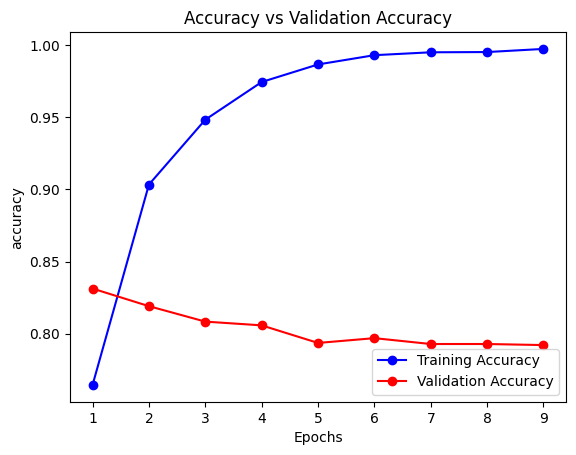

In [54]:
## plotting accuracy vs validation accuracy
import matplotlib.pyplot as plt

def plot_accuracy(history):
  acc = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
  plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
  plt.title("Accuracy vs Validation Accuracy")
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('accuracy')
  plt.show()
plot_accuracy(history)

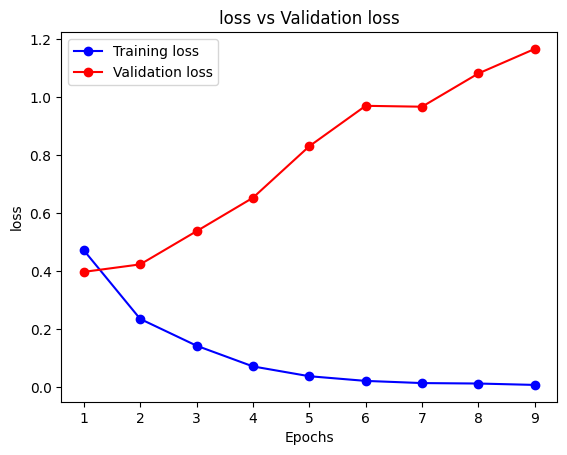

In [55]:
## plotting loss vs validation loss
import matplotlib.pyplot as plt

def plot_accuracy(history):
  acc = history.history['loss']
  val_accuracy = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo-', label='Training loss')
  plt.plot(epochs, val_accuracy, 'ro-', label='Validation loss')
  plt.title("loss vs Validation loss")
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('loss')
  plt.show()
plot_accuracy(history)

## Reducing Overfitting in Language Models

In [57]:
from tensorflow.keras.optimizers import Adam

model = tf.keras.Sequential([

          ## Exploring embedding dimensions
          tf.keras.layers.Embedding(input_dim=20000, output_dim=32, input_length=maxlen),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.2)),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.2)),

          ## Using regularization
          tf.keras.layers.Dense(24, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),

          ## Using Dropout
          tf.keras.layers.Dropout(.3),
          tf.keras.layers.Dense(1, activation='sigmoid')
        ])

## Adjusting the learning rate
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.00003,beta_1=0.90, beta_2=0.999, amsgrad=False),
              metrics=['accuracy']
              )
history = model.fit(
    training_padded, training_labels,
    epochs=30,
    validation_data=(testing_padded, testing_labels),
    callbacks=[early_stop],
    batch_size=32
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.5472 - loss: 1.0142 - val_accuracy: 0.5748 - val_loss: 0.9477
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5653 - loss: 0.9338 - val_accuracy: 0.5748 - val_loss: 0.8842
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5591 - loss: 0.8741 - val_accuracy: 0.5792 - val_loss: 0.8239
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.6214 - loss: 0.7956 - val_accuracy: 0.7390 - val_loss: 0.6735
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7885 - loss: 0.6080 - val_accuracy: 0.7730 - val_loss: 0.5918
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8237 - loss: 0.5255 - val_accuracy: 0.7800 - val_loss: 0.5637
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8407 - loss: 0.4739 - val_accuracy: 0.7870 - val_loss: 0.5407
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.8608 - loss: 0.4265 - val_accurac

In [58]:
from sklearn.metrics import classification_report, confusion_matrix
preds = (model.predict(testing_padded) > 0.5).astype("int32")
print(confusion_matrix(testing_labels, preds))
print(classification_report(testing_labels, preds))

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[[1322  235]
 [ 310  842]]
              precision    recall  f1-score   support

         0.0       0.81      0.85      0.83      1557
         1.0       0.78      0.73      0.76      1152

    accuracy                           0.80      2709
   macro avg       0.80      0.79      0.79      2709
weighted avg       0.80      0.80      0.80      2709



## Using Pretrained Embeddings with RNNs

In [69]:
# 1) Download the GloVe Twitter archive
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip -O /tmp/glove.zip

# 2) Unzip just the 25‑dim vectors into /tmp
!unzip /tmp/glove.zip glove.twitter.27B.25d.txt -d /tmp

--2025-07-24 17:16:00--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2025-07-24 17:16:00--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2025-07-24 17:16:01--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [ap

In [73]:
glove_embeddings = dict()
f = open('/tmp/glove.twitter.27B.25d.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  glove_embeddings[word] = coefs
f.close()

In [76]:
glove_dim = 25
vocab_size = 20000

embedding_matrix = np.zeros((vocab_size, glove_dim))

for word, idx in tokenizer.word_index.items():
    if idx >= vocab_size:
        continue
    vec = glove_embeddings.get(word)
    if vec is not None:
        embedding_matrix[idx] = vec


In [77]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=glove_dim, input_length=maxlen, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(embedding_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.00003,beta_1=0.90, beta_2=0.999, amsgrad=False),
              metrics=['accuracy']
              )
history = model.fit(
    training_padded, training_labels,
    epochs=30,
    validation_data=(testing_padded, testing_labels),
    callbacks=[early_stop],
    batch_size=32
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.5633 - loss: 0.6785 - val_accuracy: 0.6685 - val_loss: 0.6130
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.6915 - loss: 0.5913 - val_accuracy: 0.6918 - val_loss: 0.5825
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7117 - loss: 0.5627 - val_accuracy: 0.7132 - val_loss: 0.5616
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7220 - loss: 0.5510 - val_accuracy: 0.7254 - val_loss: 0.5494
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.7431 - loss: 0.5270 - val_accuracy: 0.7313 - val_loss: 0.5387
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7490 - loss: 0.5166 - val_accuracy: 0.7309 - val_loss: 0.5363
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7494 - loss: 0.5114 - val_accuracy: 0.7368 - val_loss: 0.5273
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7544 - loss: 0.5013 - val_accuracy

## Making Prediction

In [78]:
sarcastic_sentences = [
    "Oclinton becomes first president to clear 18 feet in pole vault",
    "I love when my phone dies in the middle of a call—super convenient.",
    "Wow, you finally showed up. Only took you all day.",
    "Of course I studied for the test—I just enjoy failing.",
    "Nothing beats working all weekend. So relaxing!",
    "Yeah, because binge-watching Netflix all night was a great life decision.",
    "I totally wanted to spill coffee on my white shirt today.",
    "Sure, I *meant* to send that embarrassing text to my boss.",
    "Perfect! The internet went down right when I started my assignment."
]

In [79]:
sequences1 = tokenizer.texts_to_sequences(sarcastic_sentences)
padded1 = pad_sequences(sequences1, maxlen=maxlen, padding="post", truncating="post")
print("sarcastic_sentences Prediction")

print(model.predict(padded1))

sarcastic_sentences Prediction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
[[0.93362254]
 [0.7709227 ]
 [0.57359684]
 [0.2573751 ]
 [0.16374725]
 [0.283965  ]
 [0.4228296 ]
 [0.709044  ]
 [0.28973496]]


In [80]:
non_sarcastic_sentences = [
    "He completed the assignment before the deadline.",
    "I like how this app helps me stay organized.",
    "They are planning a trip to New York next month.",
    "I’m learning how to cook Italian food.",
    "She smiled when she saw the surprise gift."
]

In [81]:
sequences2 = tokenizer.texts_to_sequences(non_sarcastic_sentences)
padded2 = pad_sequences(sequences2, maxlen=maxlen, padding="post", truncating="post")
print("non_sarcastic_sentences Prediction")
print(model.predict(padded2))

non_sarcastic_sentences Prediction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
[[0.3099995 ]
 [0.08870069]
 [0.44017738]
 [0.03233751]
 [0.07692438]]


In [31]:
from keras.saving import save_model
save_model(model, '/content/drive/MyDrive/Sarcasm-Detector/sarcasm.keras')